In [16]:
import numpy as np
import matplotlib.pyplot as plt

from numpy import savetxt
from astropy.io import ascii
from astropy.time import Time
from scipy.optimize import curve_fit
from astropy.timeseries import LombScargle
from scipy.stats import median_absolute_deviation

from collections import deque
from bisect import insort, bisect_left
from itertools import islice

In [17]:
clip_distance, window_size = 0.1, 12
def running_median_insort(seq, window_size):
    """Contributed by Peter Otten"""
    seq = iter(seq)
    d = deque()
    s = []
    result = []
    for item in islice(seq, window_size):
        d.append(item)
        insort(s, item)
        result.append(s[len(d)//2])
    m = window_size // 2
    for item in seq:
        old = d.popleft()
        d.append(item)
        del s[bisect_left(s, old)]
        insort(s, item)
        result.append(s[m])
    return result

def binner(bins, time, flux):
    means, errors = [], []
    midpoints = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
    for i in range(len(bins)-1):
        binned_mask = (time < bins[i+1])*(time > bins[i])
        means.append(np.mean(flux[binned_mask]))
        errors.append(np.std(flux[binned_mask])/np.sqrt(len(flux[binned_mask])))
    return means, errors, midpoints

## Normalising it all

In [18]:
tess = ascii.read('j1407_tess_new_elenor.txt')
#road = ascii.read('road_new.csv')

In [19]:
time = tess['col1']
flux = tess['col2']
eflux = tess['col3']

mask = (time > 1602.2)*(eflux < 1000)*(flux > 100)*(time < 1623) 

time = time[mask]
flux = flux[mask]
eflux = eflux[mask]

shaky_mask = (time > 1609.2) * (time < 1614.5) #The earth reflection happens here
time = time[~shaky_mask]
flux = flux[~shaky_mask]
eflux = eflux[~shaky_mask]

flux_norm = flux/np.median(flux)
eflux_norm = eflux/np.median(flux)

time_fu = time
flux_fu = flux_norm
eflux_fu = eflux_norm

fu_sorted = sorted(flux_fu)
cdf = np.cumsum(fu_sorted)/np.cumsum(fu_sorted)[-1]
lower, upper = np.interp([0.05, 0.95], cdf, fu_sorted)
print("The amplitude is ", '{0:.4f}'.format((upper-lower)/2))

The amplitude is  0.0550


## Median Clipping

In [20]:
median_mask = (flux_fu > running_median_insort(flux_fu, window_size)+ np.array([clip_distance]*len(flux_fu)))
time_f, flux_f, eflux_f = time_fu[~median_mask], flux_fu[~median_mask], eflux_fu[~median_mask]

print("Scatter is", np.std(flux_f))

Scatter is 0.03744747896289413


In [21]:
# find a0,a1,a2,a3,a4 that is the best fit to the plot above

def ringaling(phi,*c):
    # c is a numpy array containing an odd number of coeffieicnts
    # so that c[0] + c[1]*np.sin(phi) + c[2]*np.cos(phi) + c[3]*np.sin(2*phi) + c[4]*np.cos(2*phi) + .....
    #if (c.size%2 == 0):
    #    print('whoa! we need an odd number of coefficients in c')
    #    return 1
    c = np.array(c)
    npairs = (c.size-1)/2
    result = 0
    for i in np.arange(npairs):
        a_sin = c[((i*2)+1).astype(int)]
        a_cos = c[((i*2)+2).astype(int)]
        result = result + a_sin*np.sin(phi*(i+1)) + a_cos*np.cos(phi*(i+1))
    return result+c[0]

In [22]:
frequencies = 1/np.linspace(2, 5, 3000)
power = LombScargle(time_f, flux_f-np.mean(flux_f), dy = eflux_f).power(frequencies)
max_period = 1/frequencies[list(power).index(np.max(power))]
print("The highest power period is ", '{0:.3f}'.format(max_period), ' days.')

time_folded = time_f%max_period
means, errors, midpoints = binner(np.linspace(0, max_period, 50), time_folded, flux_f)

popt, pcov = curve_fit(ringaling, np.array(midpoints)*2*np.pi/(max_period), means, sigma = errors, absolute_sigma = True, p0 = [1,0,0, 1, 1])
print("The best fit parameters are ", popt)
phi = np.arange(200)*2*np.pi / 200

print(np.max(ringaling(phi, *popt)), np.min(ringaling(phi, *popt)))

flux_32_corr = flux_f-ringaling(time_folded*2*np.pi/(max_period), *popt)

#Unbinned fit [ 0.98553516 -0.02888544  0.03155577  0.00963583 -0.00272195]
#Binned fit [ 0.98650794 -0.02922539  0.03292504  0.00910987 -0.00141807]

The highest power period is  3.200  days.
The best fit parameters are  [ 0.9856859  -0.04245532  0.02329002  0.00643448  0.00681317]
1.0257403996184933 0.9280540384214339


In [23]:
frequencies = 1/np.linspace(2, 10, 3000)
power = LombScargle(time_f, flux_32_corr-np.mean(flux_32_corr), dy = eflux_f).power(frequencies)
max_period = 1/frequencies[list(power).index(np.max(power))]
print("The highest power period is ", '{0:.3f}'.format(max_period), ' days.')

time_folded = time_f%max_period
means, errors, midpoints = binner(np.linspace(0, max_period, 50), time_folded, flux_32_corr)

popt, pcov = curve_fit(ringaling, np.array(midpoints)*2*np.pi/(max_period), means, sigma = errors, absolute_sigma = True, p0 = [1,0,0, 1, 1])
print("The best fit parameters are ", popt)
phi = np.arange(200)*2*np.pi / 200

#Unbinned fit [ 9.99227834e-01  1.52563563e-03  9.68944419e-03 -4.21332667e-03 8.50444969e-04]
#Binned fit [ 1.00060393e+00  8.86011777e-04  9.98378584e-03 -3.15840939e-03 1.58680762e-04]

flux_32et42_corr = flux_32_corr-ringaling(time_folded*2*np.pi/(max_period), *popt)

The highest power period is  8.330  days.
The best fit parameters are  [-0.0008093  -0.0054403   0.00635436 -0.00316363  0.00040704]


In [24]:
frequencies = 1/np.linspace(2, 10, 3000)
power = LombScargle(time_f, flux_32et42_corr-np.mean(flux_32et42_corr), dy = eflux_f).power(frequencies)
max_period = 1/frequencies[list(power).index(np.max(power))]
print("The highest power period is ", '{0:.3f}'.format(max_period), ' days.')

time_folded = time_f%max_period
means, errors, midpoints = binner(np.linspace(0, max_period, 50), time_folded, flux_32et42_corr)

popt, pcov = curve_fit(ringaling, time_folded*2*np.pi/(max_period), flux_32et42_corr, sigma = eflux_f, absolute_sigma = True, p0 = [1,0,0, 1, 1])
print("The best fit parameters are ", popt)
phi = np.arange(200)*2*np.pi / 200


The highest power period is  3.395  days.
The best fit parameters are  [-0.00060226 -0.00226157 -0.00350479 -0.00136681 -0.0006461 ]


The highest power period is  3.395  days.
The highest power period is  3.200  days.


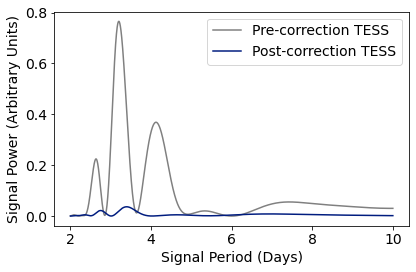

In [25]:
frequencies_corr = 1/np.linspace(2, 10, 3000)
power_corr = LombScargle(time_f, flux_32et42_corr-np.mean(flux_32et42_corr), dy = eflux_f).power(frequencies_corr)
max_period_corr = 1/frequencies_corr[list(power).index(np.max(power))]
print("The highest power period is ", '{0:.3f}'.format(max_period_corr), ' days.')

frequencies = 1/np.linspace(2, 10, 3000)
power = LombScargle(time_f, flux_f-np.mean(flux_f), dy = eflux_f).power(frequencies)
max_period = 1/frequencies[list(power).index(np.max(power))]
print("The highest power period is ", '{0:.3f}'.format(max_period), ' days.')


import matplotlib
plt.style.use('seaborn-dark-palette')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
matplotlib.rc('font', **font)


plt.plot(1/frequencies, power, label='Pre-correction TESS', color='grey')
#power_lim = plt.set_ylim()

plt.plot(1/frequencies_corr, power_corr, label='Post-correction TESS')
#plt.set_ylim(power_lim)
plt.legend()
plt.xlabel('Signal Period (Days)')
plt.ylabel('Signal Power (Arbitrary Units)')
#plt.title('Tess periodogram')
plt.tight_layout()
plt.savefig('TESS_periodogram.pdf')